Objectif : Transformer un nombre p de bandes d'un spectre en un vecteur des probabilités que le point appartienne à une des k classes -> renvoyer la classe correspondant à la probabilité la plus grande

In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [2]:
##Téléchargement des données

X_data=loadmat("pavia_X.mat")['pavia']
y_data=loadmat("pavia_y.mat")['pavia_gt']

X_train=X_data[201:,0:,:]
y_train=y_data[201:,0:]

X_test=X_data[:200,0:,:]
y_test=y_data[:200,0:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(895, 715, 102)
(895, 715)
(200, 715, 102)
(200, 715)


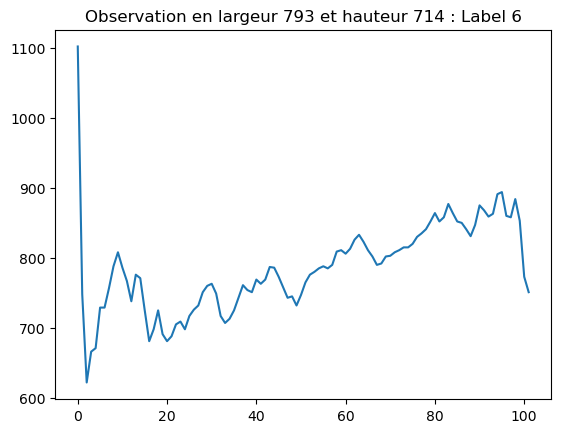

In [3]:
##Définition de la fonction d'observation

def ShowPaviaObservation(X_data,y_data,l=0,h=0): #l=largeur et h=hauteur
    plt.plot(X_data[l,h,:])
    plt.title('Observation en largeur '+str(l)+' et hauteur '+str(h)+' : Label '+str((y_data[l,h])))
    plt.show()

ShowPaviaObservation(X_train,y_train,793,714)


In [4]:
##Conversion uint16 -> int32

X_train_int32 = X_train.astype(np.int32)
X_test_int32 = X_test.astype(np.int32)

In [5]:
##Conversion en tenseur

torch_X_train = torch.from_numpy(X_train_int32).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test_int32).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [6]:
##Mise à plat

torch_X_train = torch.flatten(torch_X_train, end_dim=-2)
torch_y_train = torch.flatten(torch_y_train)

torch_X_test = torch.flatten(torch_X_test, end_dim=-2)
torch_y_test = torch.flatten(torch_y_test)

In [7]:
#CNN simple : 6*51 / reshape.(-1,1,102)

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(6, 6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(6, 6, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(25*6, 64)
        self.fc2 = nn.Linear(64, 10)
        
        self.soft=nn.Softmax()
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        
        x = x.view(-1, 25*6)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.soft(x) #ne peut pas être utilisé en mm temps que cross entropy loss
        
        return(x)

cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv1d(1, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(6, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(6, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=150, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (soft): Softmax(dim=None)
)


In [8]:
def fit(model,X_data,y_data, EPOCHS = 5, BATCH_SIZE = 32, frequencySvg=50):
    
    optimizer = torch.optim.Adam(model.parameters())
    error = nn.binary_cross_entropy_with_logits()
    model.train()
    
    n=X_data.shape[0]
    
    List_PrctGoodPredict=[]
    
    for epoch in range(EPOCHS):
        
        batch_start=0
        batchNb=0
        
        while batch_start+BATCH_SIZE < n:
            
            #Descente de gradient stochastique
            var_X_batch = X_data[batch_start:batch_start+BATCH_SIZE,:].reshape(-1,1,102).float() #reshape pour compatibilité
            var_y_batch = y_data[batch_start:batch_start+BATCH_SIZE]
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()
            
            #Update
            batch_start+=BATCH_SIZE
            batchNb+=1
            
            #Nombre de prédictions correctes
            predicted = torch.max(output.data, 1)[1]
            
            PrctGoodPredict = (100./BATCH_SIZE)*float((predicted == var_y_batch.view(-1)).sum())

            if batchNb%frequencySvg==0:
                print("epoch="+str(epoch)+" -- batch start="+str(batch_start)+" -> Prct good predictions="+str(PrctGoodPredict))
                
            List_PrctGoodPredict.append(PrctGoodPredict)
            
    print("Moyenne du pourcentage de bonnes prédictions sur les données :")
    print(sum(List_PrctGoodPredict)/len(List_PrctGoodPredict),"%")

    return List_PrctGoodPredict

In [9]:
cnn = CNN()
List_PrctGoodPredict_CNN=fit(cnn,torch_X_train,torch_y_train,EPOCHS=4,BATCH_SIZE = 100)


AttributeError: module 'torch.nn' has no attribute 'binary_cross_entropy_with_logits'

In [10]:
plt.plot(List_PrctGoodPredict_CNN,'r')
plt.xlabel('Iterations')
plt.ylabel('Prct good predictions')
plt.show()

NameError: name 'List_PrctGoodPredict_CNN' is not defined

In [32]:
Y_pred = cnn(torch_X_test.view(-1,1,102).float())

In [38]:

Y_pred.shape

torch.Size([67925, 10])

In [43]:
torch.argmax(Y_pred[100:105,:],dim=1)

tensor([0, 0, 0, 0, 0])

In [48]:
torch_y_test[50075:50080]

tensor([0, 0, 0, 0, 0])